In [2]:
import sys
sys.path.append("./tools")

In [3]:
import numpy as np

import qiskit
from qiskit import QuantumCircuit
from qiskit import execute, Aer

simulator = Aer.get_backend('qasm_simulator')

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
palette = {
    'unitary': '#FF9966', 'vqc': '#66CC99', 
}

In [6]:
%matplotlib inline

In [7]:
%%html
<style>
table {float:left;}
</style>

## Tool Modules

In [8]:
from quantum import *
from measurements import *

from unitary import *
from VQC import *

from dataSL import *
from QOLearner import *

from noise import *
from lipschitz import *

## Prepare Circuits

In [9]:
# https://www.quantum-inspire.com/kbase/grover-algorithm/

### - Input Circuits

In [10]:
def initCircuit(n=3):
    circuit = QuantumCircuit(n, n)
    
    for i in range(n):
        circuit.h(i)
        circuit.barrier(i)
    
    return circuit

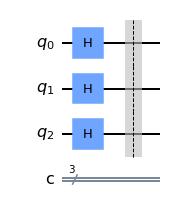

In [11]:
inputCircuit = initCircuit()
inputCircuit.draw(output='mpl')

### - Output Circuits

In [12]:
def createDiffuser():
    circuit = QuantumCircuit(3, 3)
    
    # diffuser
    circuit.h(2)
    circuit.h(0)
    circuit.h(1)
    circuit.x(2)
    circuit.x(0)
    circuit.x(1)
    circuit.h(2)
    circuit.ccx(0, 1, 2)
    circuit.barrier(0)
    circuit.barrier(1)
    circuit.h(2)
    circuit.x(2)
    circuit.x(0)
    circuit.x(1)
    circuit.h(0)
    circuit.h(1)
    circuit.h(2)
    
    return circuit

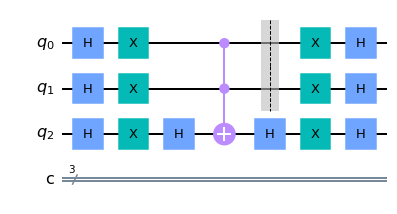

In [14]:
diffuserCircuit = createDiffuser()
diffuserCircuit.draw(output='mpl')

## Train paramters

In [16]:
import time
import sys
stdout = sys.stdout

In [17]:
# experiments times
MAX_TIMES = 10

### - expecetd

In [18]:
expected = {"110": 1}

## Strategy: unitary

In [19]:
qol_unitary = QOLearnerBase([inputCircuit, diffuserCircuit], 3, [0, 1, 2], expected)

In [35]:
times_unitary = []

for i in range(MAX_TIMES):
    start = time.perf_counter()
    qol_unitary.fit(epoch=1000, strategy='unitary', stepsize=0.003, early_stopping=True, regularization_lambda=1)
    end = time.perf_counter()
    times_unitary.append(end - start)
    
    print(f'Fin - No. {i + 1}')
    
    saveParams(qol_unitary.params[-1], 'grover_r', 'unitary', i + 1)
    saveLosses(qol_unitary.losses, 'grover_r', 'unitary', i + 1)

epoch: [1/1000] - loss: (0.14193233778498643+0j) end.
epoch: [2/1000] - loss: (0.13846887668827543+0j) end.
epoch: [3/1000] - loss: (0.13483759728787542+0j) end.
epoch: [4/1000] - loss: (0.13104489613364698+0j) end.
epoch: [5/1000] - loss: (0.12709850471293857+0j) end.
epoch: [6/1000] - loss: (0.12301292291072712+0j) end.
epoch: [7/1000] - loss: (0.11880543709809833+0j) end.
epoch: [8/1000] - loss: (0.11449443357498967+0j) end.
epoch: [9/1000] - loss: (0.11009904204411552+0j) end.
epoch: [10/1000] - loss: (0.10563901746217277+0j) end.
epoch: [11/1000] - loss: (0.10113466044965394+0j) end.
epoch: [12/1000] - loss: (0.09660671137968584+0j) end.
epoch: [13/1000] - loss: (0.0920760986961021+0j) end.
epoch: [14/1000] - loss: (0.08756360633235719+0j) end.
epoch: [15/1000] - loss: (0.08308943508952314+0j) end.
epoch: [16/1000] - loss: (0.07867290759927319+0j) end.
epoch: [17/1000] - loss: (0.07433227057947937+0j) end.
epoch: [18/1000] - loss: (0.07008457945592056+0j) end.
epoch: [19/1000] - l

KeyboardInterrupt: 

In [21]:
print(f'Average times for unitary: {np.mean(times_unitary)}')

Average times for unitary: 61.368883040000036


### - plot a loss example

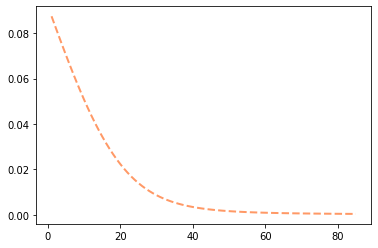

In [22]:
plot(loadLosses('grover_r', 'unitary', 3), color=palette['unitary'])

In [23]:
losses_unitary= []
max_length = 0
for i in range(MAX_TIMES):
    losses_unitary.append(loadLosses('grover_r', 'unitary', i + 1))
    max_length = max(max_length, len(losses_unitary[-1]))

for i in range(MAX_TIMES):
    length = len(losses_unitary[i])
    while length < max_length:
        losses_unitary[i].append(losses_unitary[i][-1])
        length += 1

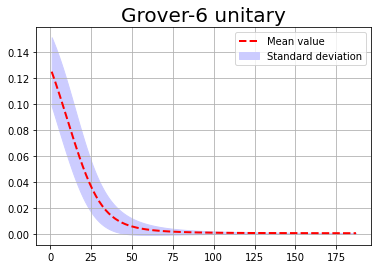

In [24]:
plotLosses(losses_unitary, title='Grover-6 unitary')

### - average time and loss

In [25]:
average_loss_unitary = 0.0
for i in range(MAX_TIMES):
    loss = loadLosses('grover_r', 'unitary', i + 1)[-1]
    average_loss_unitary += loss
print(f'Average loss for unitary: {average_loss_unitary / MAX_TIMES}')

Average loss for unitary: (0.00043915981386245817+0j)


In [26]:
average_epoch_unitary = 0
for i in range(MAX_TIMES):
    loss = loadLosses('grover_r', 'unitary', i + 1)
    average_epoch_unitary += len(loss)
print(f'Average epoch for unitary: {average_epoch_unitary / MAX_TIMES}')

Average epoch for unitary: 104.7


In [27]:
average_time_unitary = 61.368883040000036

In [28]:
average_time_per_epoch_unitary = average_time_unitary / average_epoch_unitary
print(f'Average time per epoch for unitary: {average_time_per_epoch_unitary}')

Average time per epoch for unitary: 0.058614023915950365


|Strategy| parameterized unitary |
|:----------------:|:-----:|
| Average loss | 6.146e-4 |
| Average time | 96.852 |
| Average epochs | 145.6 |
| Average time per epoch | 0.06652 |

## Strategy: VQC

In [42]:
qol_vqc = QOLearnerBase([inputCircuit, diffuserCircuit], 3, [0, 1, 2], expected)

In [34]:
times_vqc = []

for i in range(MAX_TIMES):
    start = time.perf_counter()
    qol_vqc.fit(epoch=1000, strategy='vqc', stepsize=0.003, early_stopping=True,  regularization_lambda=1)
    end = time.perf_counter()
    times_vqc.append(end - start)
    print(f'Fin - No. {i + 1}')
    
    saveParams(qol_vqc.params[-1], 'grover_r', 'vqc', i + 1)
    saveLosses(qol_vqc.losses, 'grover_r', 'vqc', i + 1)

NameError: name 'qol_vqc' is not defined

In [46]:
print(f'Average times for vqc: {np.mean(times_vqc)}')

Average times for vqc: 78.20693336000004


### - plot a loss example

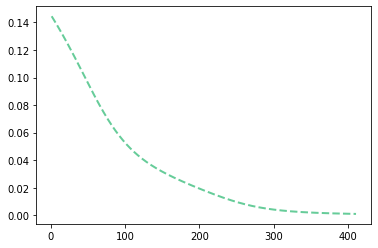

In [48]:
plot(loadLosses('grover_r', 'vqc', 1), color=palette['vqc'])

In [49]:
losses_vqc= []
max_length = 0
for i in range(10):
    losses_vqc.append(loadLosses('grover_r', 'vqc', i + 1))
    max_length = max(max_length, len(losses_vqc[-1]))

for i in range(10):
    length = len(losses_vqc[i])
    while length < max_length:
        losses_vqc[i].append(losses_vqc[i][-1])
        length += 1

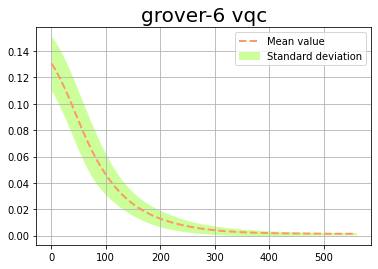

In [50]:
plotLosses(losses_vqc, color="#FF9966", fill_color="#CCFF99", title="grover-6 vqc")

### - average time and loss

In [45]:
average_loss_vqc = 0.0
for i in range(MAX_TIMES):
    loss = loadLosses('grover', 'vqc', i + 1)[-1]
    average_loss_vqc += loss
print(f'Average loss for vqc: {average_loss_vqc / MAX_TIMES}')

Average loss for vqc: (0.0014480085252654012+0j)


In [46]:
average_epoch_vqc = 0
for i in range(MAX_TIMES):
    loss = loadLosses('grover', 'vqc', i + 1)
    average_epoch_vqc += len(loss)
print(f'Average epoch for vqc: {average_epoch_vqc / MAX_TIMES}')

Average epoch for vqc: 448.9


In [47]:
average_time_vqc = 92.09989926

In [48]:
average_time_per_epoch_vqc = average_time_vqc / average_epoch_vqc
print(f'Average time per epoch for vqc: {average_time_per_epoch_vqc}')

Average time per epoch for vqc: 0.020516796449097794


| Strategy | VQC |
|:----------------:|:-----:|
| Average loss | 1.448e-3 |
| Average time | 92.10 |
| Average epochs | 448.9 |
| Average time per epoch | 0.02052 |

##  Summarize

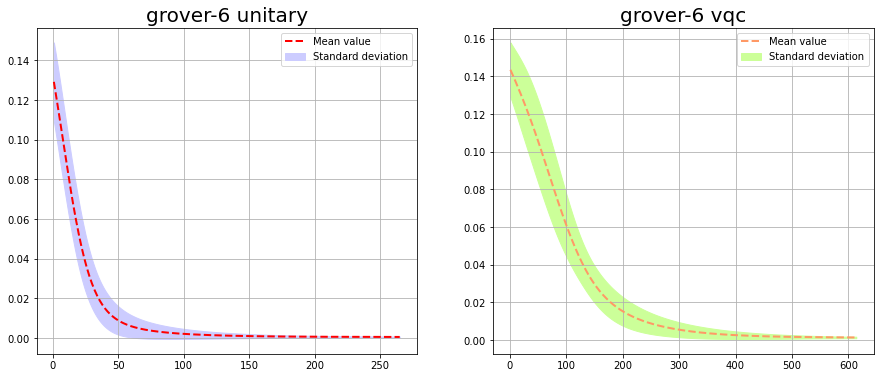

In [31]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plotLosses(losses_unitary, title="grover-6 unitary")
plt.subplot(1,2,2)
plotLosses(losses_vqc, color="#FF9966", fill_color="#CCFF99", title="grover-6 vqc")

|Strategy| parameterized unitary |VQC |
|:----------------:|:-----:|:-----:|
| Average loss | 6.146e-4 | 1.448e-3 |
| Average time | 96.852 | 92.10 |
| Average epochs | 145.6 |448.9 |
| Average time per epoch | 0.06652 |0.02052 |

## Compare Lipschitz

In [30]:
measurements = getMeasurements(3)

In [31]:
names = ['unitary', 'vqc']

In [32]:
error_params = [
    [0.0001 , 'b'], [0.0001 , 'p'], [0.0001 , 'd'], 
    [0.001 , 'b'], [0.001 , 'p'], [0.001 , 'd'], 
    [0.01 , 'b'], [0.01 , 'p'], [0.01 , 'd'],
    [0.1 , 'b'], [0.1 , 'p'], [0.1 , 'd'], 
]

### - exact Lipschitz

In [52]:
smallestDict = { k: 0 for k in names }

for (p, errorType) in error_params:
    print(f' - p = {p}, errorType: {errorType}')
    
    # simulate noise input circuits
    noiseInputCircuits = getNoiseCircuits([inputCircuit], p, errorType)

    smallest = 1.0; smallestKey = ''
    for name in names: # unitary or vqc
        lip = 0.0
        
        for i in range(MAX_TIMES):
            # build targetCircuit
            params = loadParams('grover', name, i + 1)
            targetCircuit = QuantumCircuit(3, 3)
            
            if name == 'unitary':
                targetCircuit.append(buildU(3, params), [0, 1, 2])
            else:
                targetCircuit = getVQCCircuit(targetCircuit, 3, params, [0, 1, 2])
                
            lip += calculateExactLipschitz(
                [inputCircuit], noiseInputCircuits, 
                targetCircuit, diffuserCircuit, measurements
            )
        lip = lip / MAX_TIMES
        
        if lip < smallest:
            smallest = lip
            smallestKey = name
        
        print(f'Lipschitz for [{name}] is: {lip}\n')
    
    smallestDict[smallestKey]  += 1.0
    print(f'smallest one: [{smallestKey}]')
        
    print('-' * 25)
    print()

print(smallestDict)

 - p = 0.0001, errorType: b
Lipschitz for [unitary] is: 0.02804068356979437

Lipschitz for [vqc] is: 0.024512998338303265

smallest one: [vqc]
-------------------------

 - p = 0.0001, errorType: p
Lipschitz for [unitary] is: 0.011475409742266995

Lipschitz for [vqc] is: 0.008553197418383476

smallest one: [vqc]
-------------------------

 - p = 0.0001, errorType: d
Lipschitz for [unitary] is: 0.011475379256266386

Lipschitz for [vqc] is: 0.00855353902680296

smallest one: [vqc]
-------------------------

 - p = 0.001, errorType: b
Lipschitz for [unitary] is: 0.027684652787261156

Lipschitz for [vqc] is: 0.021821300126301853

smallest one: [vqc]
-------------------------

 - p = 0.001, errorType: p
Lipschitz for [unitary] is: 0.011475956946980897

Lipschitz for [vqc] is: 0.008547045485729545

smallest one: [vqc]
-------------------------

 - p = 0.001, errorType: d
Lipschitz for [unitary] is: 0.01147565322942903

Lipschitz for [vqc] is: 0.00855046386646848

smallest one: [vqc]
--------

<table>
    <tr>
        <th rowspan="2">Strategy</th><th rowspan="2">Error Type</th><th colspan="4">Probability</th>
    </tr>
    <tr>
                                                 <td>0.0001</td><td>0.001</td><td>0.01</td><td>0.1</td>
    </tr>
    <tr>
        <td rowspan="3">Parameterized Unitary</td><td>bit flip</td><td>0.02804</td><td>0.02768</td><td> 0.02718</td><td>0.02696</td>
    </tr>
    <tr>
        <td>phase flip</td><td>0.01148</td><td>0.01148</td><td>0.01148</td><td>0.01152</td>
    </tr>
    <tr>
        <td>depolarizing</td><td>0.01148</td><td>0.01148</td><td>0.01148</td><td>0.01150</td>
    </tr>
    <tr>
        <td rowspan="3">VQC</td><td>bit flip</td><td> 0.02451</td><td>0.02182</td><td>0.02256</td><td>0.02696</td>
    </tr>
    <tr>
        <td>phase flip</td><td>0.008553</td><td>0.008547</td><td>0.008485</td><td>0.008005</td>
    </tr>
    <tr>
        <td>depolarizing</td><td>0.008554</td><td>0.008550</td><td>0.008520</td><td>0.008204</td>
    </tr>
    
</table>

### - approximate Lipschitz

In [33]:
for name in names: # unitary or vqc
    lip = 0.0
    best_index = -1; best_lip = 1

    for i in range(MAX_TIMES):
        # build targetCircuit
        params = loadParams('grover_r', name, i + 1)
        targetCircuit = QuantumCircuit(3, 3)

        if name == 'unitary':
            targetCircuit.append(buildU(3, params), [0, 1, 2])
        else:
            targetCircuit = getVQCCircuit(targetCircuit, 3, params, [0, 1, 2])

        score = calculateLipschitz(targetCircuit, diffuserCircuit, measurements)
        
        if score < best_lip:
            best_lip = score
            best_index = i + 1
        
        lip += score
        
    lip = lip / MAX_TIMES

    print(f'Lipschitz for [{name}] is: {lip}(best params: No.{best_index}({best_lip}))\n')

Lipschitz for [unitary] is: 0.01304604277668465(best params: No.8(0.00013822188447689743))

Lipschitz for [vqc] is: 0.016084098193649643(best params: No.7(6.0839104896731605e-05))

